In [253]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [254]:
dataset = pd.read_csv('clean_color.csv') # adjust according to the name of your file

In [255]:
# Paste in here the cleaning logic from yesterday's notebook that nicely normalizes this dataset
pass

### Visualizing this dataset

Since a color is representing as a point in a 3D space, we can create a 3D scatter plot to chart the points. We color the points themselves according to the color that the point represents!

3D scatter plots are difficult to interpret, since data "in front" blocks the view of data "behind". To address this, we want to show the same scatter plot from many angles.

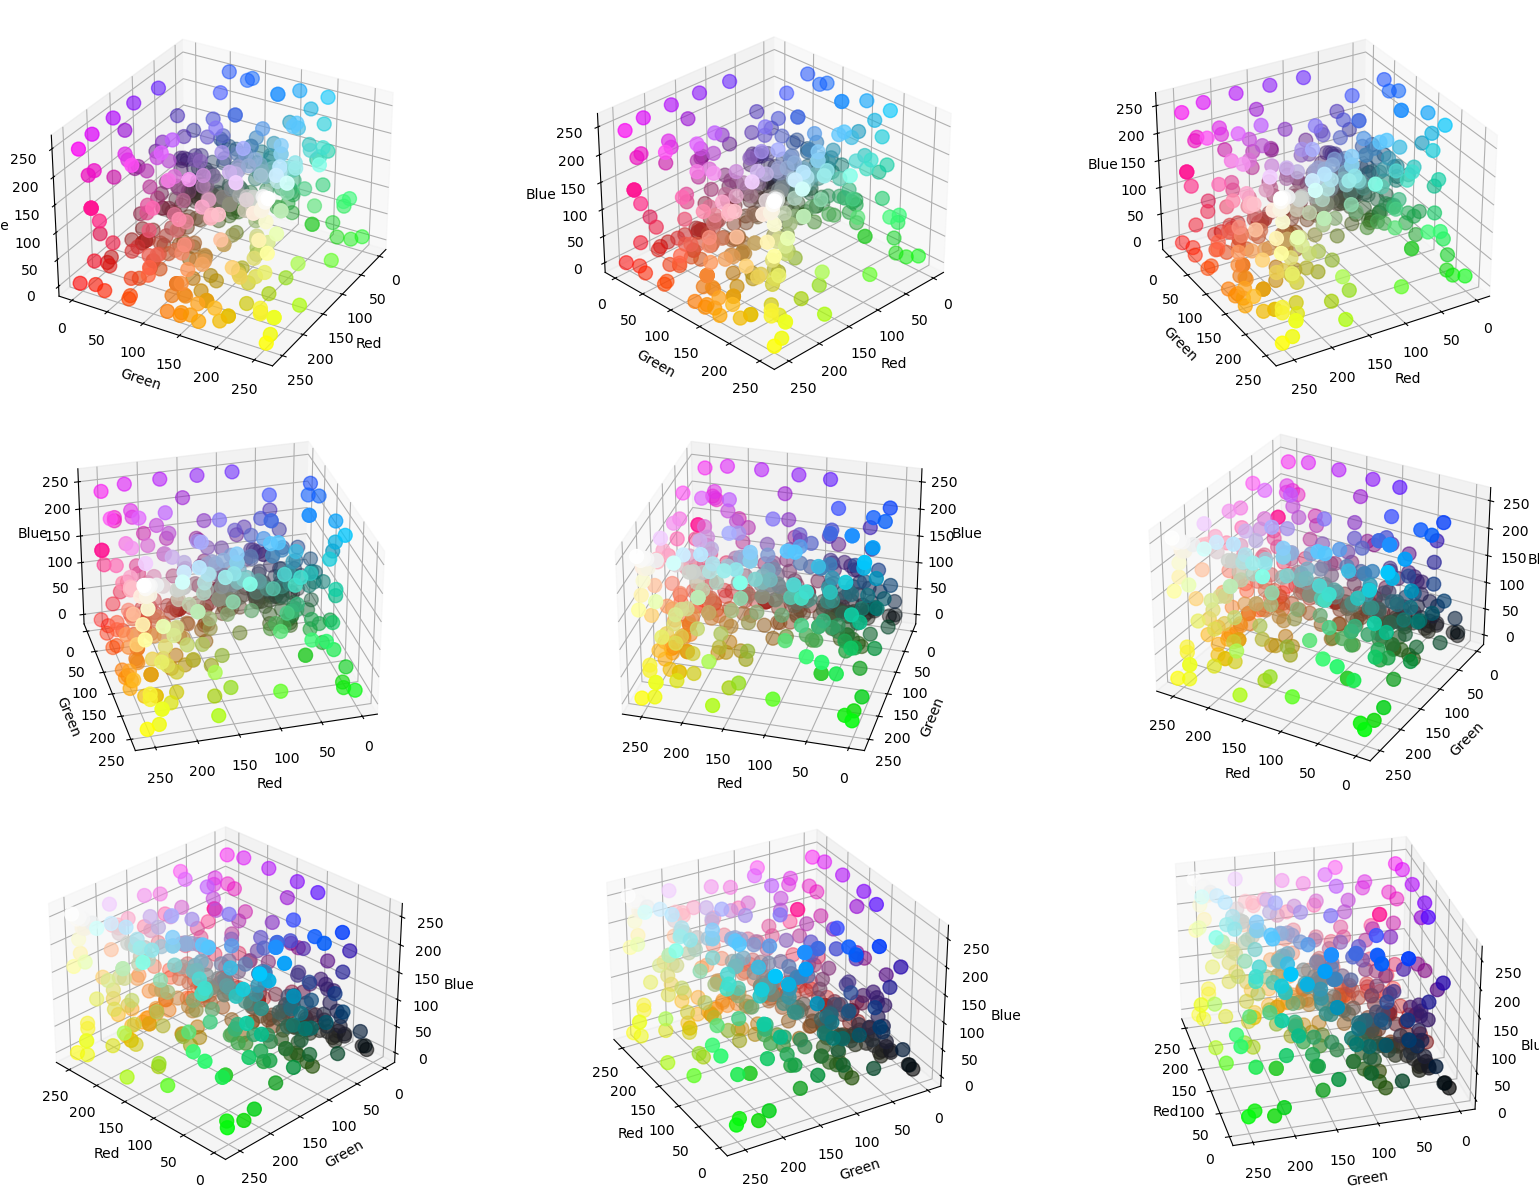

In [257]:
fig, axs = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': '3d'})
# ^ create a figure containing 9 'subplots' (3 rows x 3 columns of plots)

# Angles to view the data from. There are 9 of these.
# Try messing with some of these angles if you want to get a different look!
angles = [(30, 30), (30, 45), (30, 60), (30, 75), (30, 105), (30, 120), (30, 135), (30, 150), (30, 165)]

# Normalize RGB values to [0, 1] range for display
# If you get errors about values out of range,
# edit the CSV file in a text editor to remove any rows containing values exceeding 255
colors = dataset[['R','G','B']] / 255.0

# Plot the data from the different angles
for ax, angle in zip(axs.flat, angles):
    # Scatter plot with colors
    ax.scatter(dataset['R'], dataset['G'], dataset['B'], c=colors, s=100)
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')

plt.tight_layout()
plt.show()

### Reanalyzing the colors

Perhaps the reason we keep getting shoddy performance with our color classifier is that the labels aren't very good. After all, we applied this funny word splitting technique. Let's see what colors the _computer_ thinks are present in our dataset. To do this, we'll apply a K-means clustering to the dataset. Choose an initial K according to how many different colors you think are present in the visualization above.

In [259]:
from sklearn.cluster import KMeans

Fill in the `???` below!

In [261]:
COLOR_COUNT = 9
km = KMeans(n_clusters=COLOR_COUNT)
X = dataset[['R','G','B']]

In [262]:
# In this cell, fit the `km` clustering to the data. Check the docs or use chatgpt to see precisely how.
km.fit(X)

C:\Users\linag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=9)

### Visualizing the clusters

K-means, as part of its fitting process, computes a _centroid_ for each cluster that it identifies. In a sense, the centroid acts as a _representative_ for that cluster, since its value is the mean of the points in that cluster.

In our case, the centroid's value is again an RGB triplet, so we can visualize the centroid together with some of its corresponding cluster's members to see if our cluster makes sense.

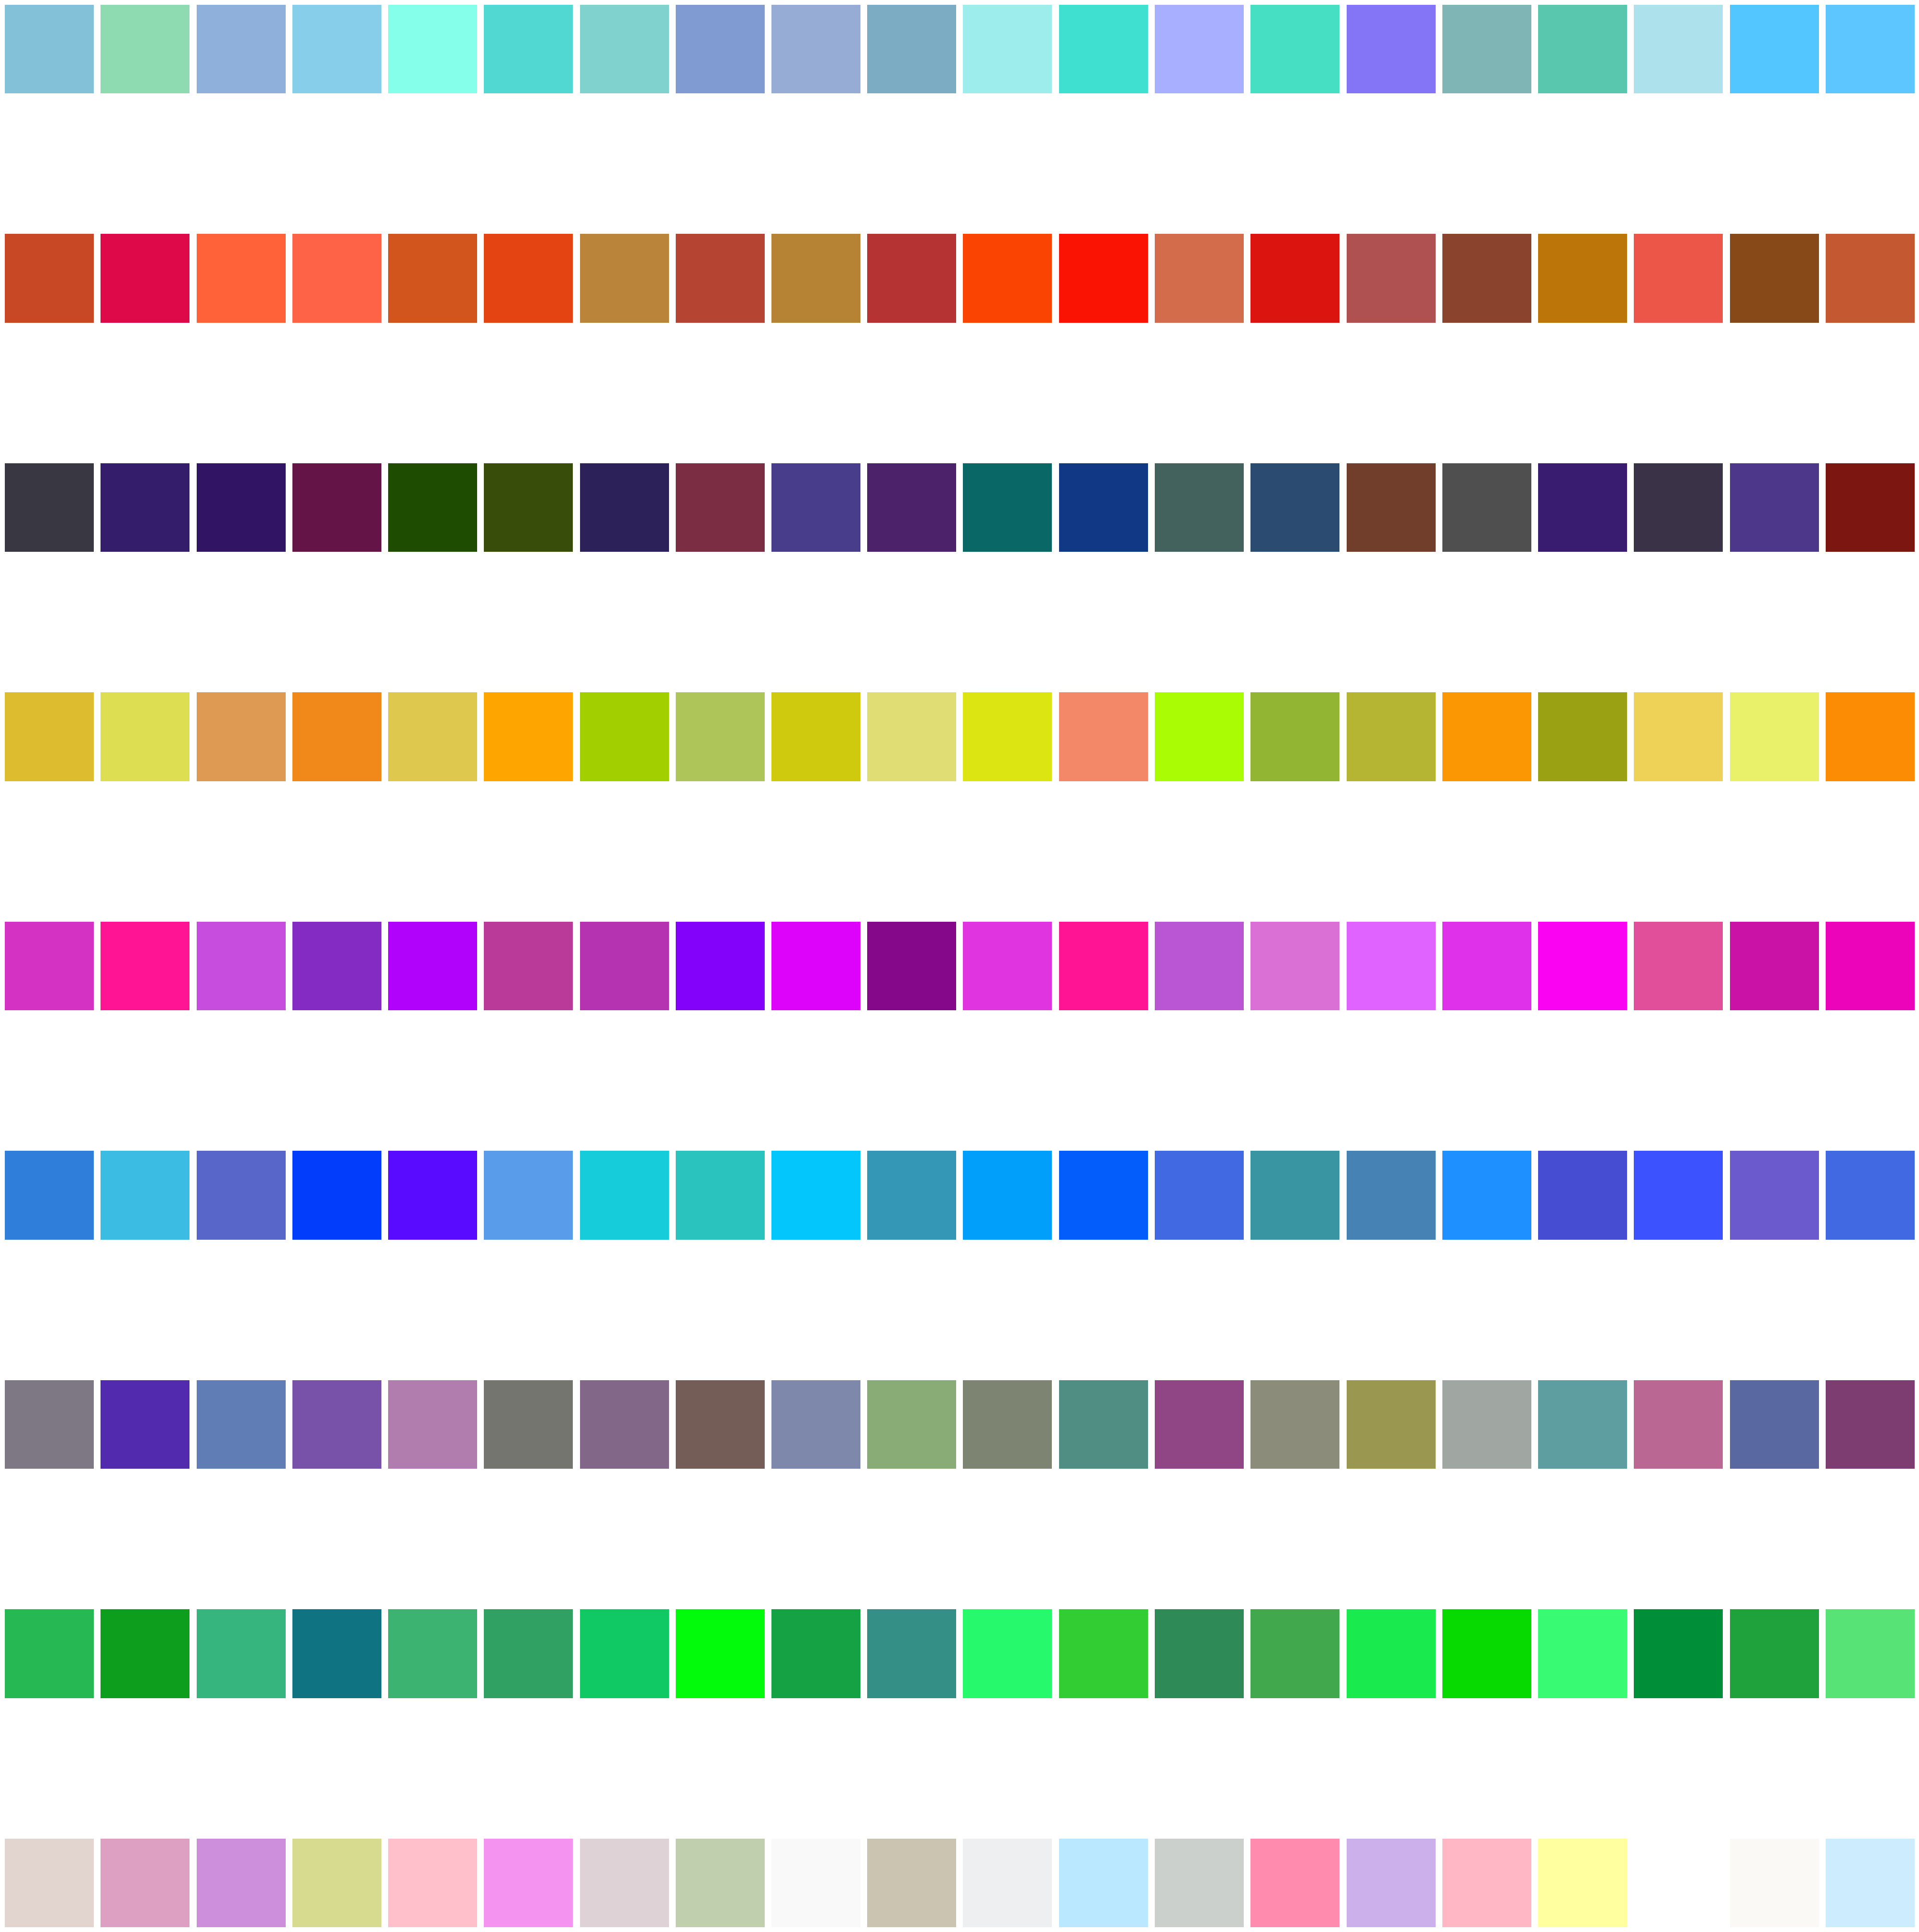

In [264]:
COLUMN_COUNT = 20
fig, axs = plt.subplots(COLOR_COUNT, COLUMN_COUNT, figsize=(2 * COLUMN_COUNT, 5 * COLOR_COUNT))

# Iterate over the RGB triplets and display each color
for i, (ax_row, centroid) in enumerate(zip(axs, km.cluster_centers_)):
    ax_row[0].imshow(np.full((10, 10, 3), centroid/255))
    ax_row[0].axis('off')  # Hide the axes
    members = np.array(X[km.labels_ == i])
    for ax, member in zip(ax_row[1:], members):
        ax.imshow(np.full((10, 10, 3), member/255))
        ax.axis('off')

# Show plot
plt.tight_layout()
plt.show()

### Interpreting the clusters

Do these clusters align with your expectations? Why or why not? If not, speculate about why K-means finds the clusters that it does instead of the ones you expect.

### Finding the 'best' number of clusters

The _silhouette score_ gives a metric to evaluate a clustering.

To refresh your memory or learn more about what the silhouette score represents, [the sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) gives a concise explanation.

In [267]:
from sklearn.metrics import silhouette_samples, silhouette_score

Whereas the `silhouette_score` function gives the _average_ silhouette score across all the samples, the `silhouette_samples` calculates the score _for each_ sample. By computing the score for each sample, it becomes possible to _visualize_ the silhouette scores as a way of assessing the quality of our clustering.

In [269]:
# In this cell, compute the average silhouette score and the scores for each sample
avg_score = silhouette_score(X, km.labels_)
sample_scores = silhouette_samples(X, km.labels_)

In [270]:
def best_color_count():
    max_v, best_i = 0, 0
    for i in range(2, 20):
        km = KMeans(n_clusters=i)
        X = dataset[['R','G','B']]
        km.fit(X)
        avg_score = silhouette_score(X, km.labels_)
        if avg_score > max_v:
            max_v = avg_score
            best_i = i
    return i
# best_color_count()

With 9 clusters, the average silhouette score is: 0.31919711768906317


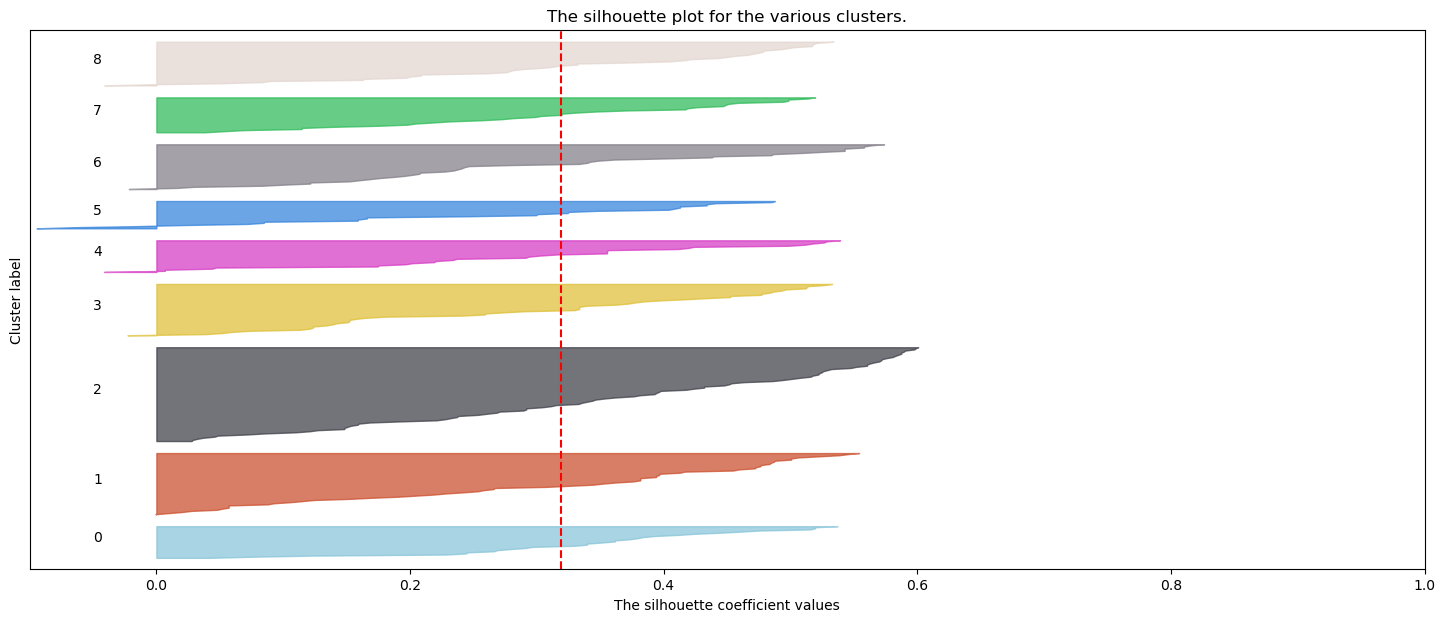

In [271]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
ax.set_xlim([-0.1, 1])
ax.set_ylim([0, len(X) + (COLOR_COUNT + 1) * 10])

ax.set_title("The silhouette plot for the various clusters.")
ax.set_xlabel("The silhouette coefficient values")
ax.set_ylabel("Cluster label")

y_lower = 10
for i in range(COLOR_COUNT):
    # select the silhouette scores of all samples belonging to the ith cluster, and sort them
    ith_color_silhouette_values = sample_scores[km.labels_ == i]
    ith_color_silhouette_values.sort()

    cluster_size_i = ith_color_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size_i
    # ^ the extra y space is to put some padding between silhouette charts

    color = km.cluster_centers_[i] / 255
    # use the color of the centroid to color this part of the chart
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_color_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    # label the silhouette plot with its cluster number at the middle
    ax.text(-0.05, y_lower + 0.5 * cluster_size_i, str(i))

    y_lower = y_upper + 10

print('With', COLOR_COUNT, 'clusters, the average silhouette score is:', avg_score)
# draw a vertical line to show where the average silhouette score is
ax.axvline(x=avg_score, color="red", linestyle="--")
ax.set_yticks([])

plt.show()